In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import analyze # takes some time since inits hax
from channel_dict import channel_dict
from tqdm import tqdm
import datetime
import pickle
from scipy.stats import norm
import shutil

%matplotlib inline

# Job Submission

In [2]:
from make_runlist_new import write_spe_lists

#dry run
write_spe_lists(write=False)

1187
cursor has 1187 runs
Number of runs and most recent run of each type
blank 44 18189
bottom 44 18190
topbulk 44 18192
topring 43 18000
Something went wrong, number of runs are not equal
blank:  [18189, 17997, 17938, 17861, 17781, 17586, 17453, 17248, 16983, 16700, 16522, 16342, 16235, 15986, 15810, 15624, 15419, 15267, 15084, 14906, 14732, 14554, 14368, 14191, 14087, 13834, 13656, 13430, 13299, 13127, 12945, 12767, 12586, 12510, 12397, 12317, 12210, 12129, 12045, 11812, 11732, 11624, 11534, 11428]
bottom:  [18190, 17998, 17939, 17862, 17782, 17587, 17454, 17249, 16984, 16701, 16523, 16343, 16237, 15987, 15811, 15625, 15420, 15268, 15085, 14907, 14733, 14555, 14369, 14192, 14088, 13837, 13657, 13433, 13300, 13128, 12946, 12768, 12587, 12511, 12398, 12318, 12211, 12130, 12046, 11813, 11733, 11625, 11535, 11429]
topbulk:  [18192, 17999, 17940, 17863, 17783, 17588, 17455, 17250, 16985, 16702, 16524, 16344, 16238, 15988, 15812, 15627, 15421, 15270, 15086, 14908, 14734, 14556, 14370, 141

In [3]:
#writes new runlists
written=write_spe_lists(write=True)
print(written)

1187
Number of runs and most recent run of each type
blank 44 18189
bottom 44 18190
topbulk 44 18192
topring 43 18000
Something went wrong, number of runs are not equal
blank:  [18189, 17997, 17938, 17861, 17781, 17586, 17453, 17248, 16983, 16700, 16522, 16342, 16235, 15986, 15810, 15624, 15419, 15267, 15084, 14906, 14732, 14554, 14368, 14191, 14087, 13834, 13656, 13430, 13299, 13127, 12945, 12767, 12586, 12510, 12397, 12317, 12210, 12129, 12045, 11812, 11732, 11624, 11534, 11428]
bottom:  [18190, 17998, 17939, 17862, 17782, 17587, 17454, 17249, 16984, 16701, 16523, 16343, 16237, 15987, 15811, 15625, 15420, 15268, 15085, 14907, 14733, 14555, 14369, 14192, 14088, 13837, 13657, 13433, 13300, 13128, 12946, 12768, 12587, 12511, 12398, 12318, 12211, 12130, 12046, 11813, 11733, 11625, 11535, 11429]
topbulk:  [18192, 17999, 17940, 17863, 17783, 17588, 17455, 17250, 16985, 16702, 16524, 16344, 16238, 15988, 15812, 15627, 15421, 15270, 15086, 14908, 14734, 14556, 14370, 14193, 14089, 13838, 136

### This will take some time to run as job submission takes several hours. Alternatively, in the terminal you can run ./submit_jobs.sh ./runlists/[runlist name] for a single runlist, or ./large_submission.sh to submit jobs for all runlists in ./runlists

In [4]:
def submit_job(file):
    command = "./submit_jobs.sh %s" % file
    print(command)
    !{command}

In [5]:
for f in written:
    submit_job(f)

# Acc Vs Time

### Calculating acceptance and error data

In [6]:
import hax
#hax already initiated when analyze is imported

from spe_acceptance import data_dir_base, rawdata_dir


def data_exists(run_number):
    data_path=os.path.join(data_dir_base, 'run_%05d.h5' %run_number)
    return os.path.exists(data_path)

def all_data_exists(runlist):
    return all([data_exists(run) for run in runlist])

def file_to_list(runlist_file):
    return [int(run) for run in runlist_file.split('.')[0].split('_')[1:4]]

def get_run_time(run):
    return hax.runs.datasets[hax.runs.datasets.number == run].start.values[0]
    
def find_file(run):
    return [f for f in os.listdir('runlists') if any(int(run)==elem for elem in file_to_list(f))]

#### Retrieves previously loaded data from pickle file

In [7]:
#all runlists
runlists = [f for f in os.listdir('./runlists')]
bottom_runs = []
accs = []

ch_acc_dict={}
ch_err_l={}
ch_err_u={}

upper_errs=[]
lower_errs=[]
errors = []

missing_runs = []
LED_off = []
resubmit_files = []

with open('/project/lgrandi/xenon1t/spe_acceptance/ch_data/ch_data.pkl', 'rb') as cd:
    if os.stat('/project/lgrandi/xenon1t/spe_acceptance/ch_data/ch_data.pkl').st_size==0:
        print('No data in pickle file')
        data=[]
    else:
        data=pickle.load(cd)
saved_runlists=[]

for runlist in runlists:
    runs=file_to_list(runlist)
    if not all_data_exists(runs):
        resubmit_files.append(runlist)
        for r in runs:
            if not data_exists(r):
                missing_runs.append(r)
                continue
        

for cd in data:
    if len(data)==0:
        continue
        
    saved_runlists.append(cd.runlist)
    
    acc=cd.acc
    on_acc=cd.on_acc
    acc_errs_l=cd.acc_errs_l
    acc_errs_u=cd.acc_errs_u
    acc_sys=cd.acc_sys
    acc_stat=cd.acc_stat
    occ=cd.occ
    occ_sys=cd.occ_sys
    occ_stat=cd.occ_stat
    
    on_channels = np.where(occ > 0.05)[0]
        
    if len(on_channels) < 200:
        LED_off.append(newest_runlist)
        print('LED likely off for ', newest_runlist)
    
    ch_acc_dict[cd.runlist]=acc
    
    #mean along axis=1 to get by channel acc, errs
    ch_err_l[cd.runlist]=np.mean(acc_errs_l**2, axis=1)
    ch_err_u[cd.runlist]=np.mean(acc_errs_u**2, axis=1)
    
    runlist = file_to_list(cd.runlist)
    
    bottom_run = runlist[0]
    topbulk_run = runlist[1]
    topring_run = runlist[2]
    
    accs.append(np.mean(on_acc))
    #mean along axis=0 to get average per runlist
    lower_errs.append(np.mean(acc_errs_l**2))
    upper_errs.append(np.mean(acc_errs_u**2))
    bottom_runs.append(bottom_run)
    
print("Data already exists for: ", saved_runlists)

Data already exists for:  ['runlist_10064_10065_10066.txt', 'runlist_10133_10134_10135.txt', 'runlist_10297_10298_10299.txt', 'runlist_10524_10525_10526.txt', 'runlist_10610_10611_10612.txt', 'runlist_10696_10697_10698.txt', 'runlist_10796_10797_10798.txt', 'runlist_10877_10878_10879.txt', 'runlist_10986_10987_10988.txt', 'runlist_11069_11070_11071.txt', 'runlist_11429_11430_11431.txt', 'runlist_11625_11626_11627.txt', 'runlist_11733_11734_11736.txt', 'runlist_11813_11814_11815.txt', 'runlist_12046_12047_12048.txt', 'runlist_12130_12131_12132.txt', 'runlist_12211_12213_12214.txt', 'runlist_12318_12319_12320.txt', 'runlist_12398_12399_12400.txt', 'runlist_12511_12512_12513.txt', 'runlist_12587_12588_12589.txt', 'runlist_12768_12769_12770.txt', 'runlist_12946_12947_12948.txt', 'runlist_13128_13129_13130.txt', 'runlist_13300_13301_13303.txt', 'runlist_13657_13658_13659.txt', 'runlist_13837_13838_13839.txt', 'runlist_14192_14193_14195.txt', 'runlist_14555_14556_14557.txt', 'runlist_14733_1

#### Calculates acceptance, errors for new runlist

In [8]:
#CHANGE TO JUST NEWEST RUNLIST

newest_runlist=find_file(sorted(bottom_runs)[-1])[0]
print(newest_runlist)
runlist = file_to_list(newest_runlist)
if not all_data_exists(runlist):
    resubmit_files.append(f)
    for r in runlist:
        if not data_exists(r):
            missing_runs.append(r)
            continue
        
    
bottom_run = runlist[0]
topbulk_run = runlist[1]
topring_run = runlist[2]
        
thresholds = analyze.get_thresholds(analyze.find_regular_run(bottom_run))
        
acc, acc_errs, acc_sys, acc_stat = analyze.acceptance_3runs(bottom_run, topbulk_run, topring_run, thresholds)
occ, occ_sys, occ_stat = analyze.occupancy_3runs(bottom_run, topbulk_run, topring_run)
    
on_channels = np.where(occ > 0.05)[0]
        
if len(on_channels) < 200:
    LED_off.append(newest_runlist)
        
on_acc = acc[on_channels]
on_occ = occ[on_channels]
        
ch_acc_dict[newest_runlist]=acc
        
acc_errs_l = acc_errs[0]
acc_errs_u = acc_errs[1]
        
ch_err_l[newest_runlist]=np.mean(acc_errs_l**2, axis=1)
ch_err_u[newest_runlist]=np.mean(acc_errs_u**2, axis=1)
        
accs.append(np.mean(on_acc))
lower_errs.append(np.mean(acc_errs_l**2))
upper_errs.append(np.mean(acc_errs_u**2))
bottom_runs.append(bottom_run)
        
cd=analyze.ch_data(newest_runlist, get_run_time(bottom_run), acc, on_acc, acc_errs_l, acc_errs_u, acc_sys, acc_stat, occ, occ_sys, occ_stat)
data.append(cd)

errors=np.array([lower_errs, upper_errs])

runlist_17939_17940_17942.txt


/home/awalsh272/SPE/SPE/analyze.py:72: RuntimeWarning: invalid value encountered in true_divide
  sigma_corr_noise=corr_noise*np.sqrt( (sigma_corr/corrections)**2 + (sigma_noise/noise)**2)


#### Dumps all data into pickle file, prints runs with LED off and runs with missing data, deletes raw data for processed runs

In [14]:
os.remove('/project/lgrandi/xenon1t/spe_acceptance/ch_data/ch_data.pkl')
with open('/project/lgrandi/xenon1t/spe_acceptance/ch_data/ch_data.pkl', 'wb') as cd:
    pickle.dump(data, cd)

#Delete raw data after processed data is in the pickle file
from get_name import get_name
no_data=[]
for runlist in runlists:
    with open(os.path.join('./runlists', runlist)) as r:
        for run in r.readlines():
            name=get_name(int(run))
            path=os.path.join(rawdata_dir, name)
            if not os.path.exists(path):
                no_data.append(run)
                print(str(run)+':' +path+" doesn't exist")
                continue
            if os.path.exists(path):
                shutil.rmtree(path)
                print("Deleting raw data for: ", run, name)
    
print("These runs are missing data: ", missing_runs)
print("LED likely off for these files: ", LED_off)

9548
:/project/lgrandi/xenon1t/spe_acceptance/rawdata/170514_0933 doesn't exist
9549
:/project/lgrandi/xenon1t/spe_acceptance/rawdata/170514_0946 doesn't exist
9550
:/project/lgrandi/xenon1t/spe_acceptance/rawdata/170514_0956 doesn't exist
9551
:/project/lgrandi/xenon1t/spe_acceptance/rawdata/170514_1007 doesn't exist
12586
:/project/lgrandi/xenon1t/spe_acceptance/rawdata/170901_0919 doesn't exist
12587
:/project/lgrandi/xenon1t/spe_acceptance/rawdata/170901_0928 doesn't exist
12588
:/project/lgrandi/xenon1t/spe_acceptance/rawdata/170901_0938 doesn't exist
12589
:/project/lgrandi/xenon1t/spe_acceptance/rawdata/170901_0947 doesn't exist
7348
:/project/lgrandi/xenon1t/spe_acceptance/rawdata/170223_1440 doesn't exist
7350
:/project/lgrandi/xenon1t/spe_acceptance/rawdata/170223_1507 doesn't exist
7351
:/project/lgrandi/xenon1t/spe_acceptance/rawdata/170223_1519 doesn't exist
7352
:/project/lgrandi/xenon1t/spe_acceptance/rawdata/170223_1531 doesn't exist
6908
:/project/lgrandi/xenon1t/spe_a

#### Resubmits jobs for runs missing data

In [15]:
for f in resubmit_files:
    runs=file_to_list(f)
    submit=os.path.join('./runlists', f)
    if runs[0]<6731:
        continue
    submit_job(submit)

#### Acceptance dataframe with channels as row index, runlists as column index

In [16]:
acc_df=pd.DataFrame(ch_acc_dict)
channels_df=pd.DataFrame({"channels": [i for i in range(0,248)]})
ch_df=pd.concat([acc_df, channels_df], axis=1)
ch_df.set_index('channels', inplace=True)
ch_df

,runlist_10064_10065_10066.txt,runlist_10133_10134_10135.txt,runlist_10297_10298_10299.txt,runlist_10524_10525_10526.txt,runlist_10610_10611_10612.txt,runlist_10696_10697_10698.txt,runlist_10796_10797_10798.txt,runlist_10877_10878_10879.txt,runlist_10986_10987_10988.txt,runlist_11069_11070_11071.txt,...,runlist_8840_8841_8842.txt,runlist_8921_8922_8923.txt,runlist_9033_9034_9036.txt,runlist_9112_9113_9114.txt,runlist_9217_9218_9219.txt,runlist_9299_9300_9301.txt,runlist_9549_9550_9551.txt,runlist_9604_9605_9606.txt,runlist_9697_9698_9699.txt,runlist_9797_9798_9799.txt
channels,,,,,,,,,,,,,,,,,,,,,
0,0.935934,0.933048,0.948865,0.928161,0.933032,0.941254,0.933194,0.938441,0.925536,0.918222,...,0.950022,0.942126,0.935104,0.944624,0.921981,0.931942,0.953557,0.925946,0.924462,0.975062
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.898585,0.902590,0.882600,0.910731,0.903367,0.918015,0.928568,0.906360,0.866086,0.971065,...,0.923718,0.921874,0.922096,0.920359,0.930164,0.919406,0.936331,0.917233,0.916742,0.949387
4,0.935251,0.931430,0.933743,0.939473,0.930238,0.926277,0.925215,0.926827,0.952267,0.910587,...,0.940850,0.950287,0.950881,0.958801,0.945898,0.952829,0.971910,0.941530,0.940044,0.918109
5,0.893286,0.896895,0.894706,0.909444,0.929588,0.921343,0.904821,0.934273,0.954174,0.996797,...,0.921440,0.958829,0.915417,0.932373,0.897670,0.911586,0.950268,0.825943,0.886214,0.705465
6,0.933109,0.941535,0.973226,0.959592,0.954232,0.930395,0.914990,0.931521,0.972174,0.732764,...,0.936713,0.977811,0.965629,0.967864,1.027510,0.924928,0.996867,0.963324,0.947332,1.000714
7,0.920966,0.925067,0.910008,0.920053,0.911571,0.921255,0.927353,0.923823,0.925880,0.924058,...,0.944497,0.952754,0.946076,0.932385,0.929059,0.949672,0.952848,0.925726,0.934177,0.930193
8,0.936240,0.930363,0.940019,0.937356,0.946239,0.944613,0.944483,0.930145,0.937096,1.007550,...,0.942042,0.956565,0.942439,0.950337,0.942828,0.944940,0.959796,0.954737,0.941421,0.968535


#### Lower, upper errors dataframes with channels as row index, runlist as column index

In [17]:
lerr_df=pd.DataFrame(ch_err_l)
ch_lerr_df=pd.concat([lerr_df, channels_df], axis=1)
ch_lerr_df.set_index('channels', inplace=True)
ch_lerr_df

,runlist_10064_10065_10066.txt,runlist_10133_10134_10135.txt,runlist_10297_10298_10299.txt,runlist_10524_10525_10526.txt,runlist_10610_10611_10612.txt,runlist_10696_10697_10698.txt,runlist_10796_10797_10798.txt,runlist_10877_10878_10879.txt,runlist_10986_10987_10988.txt,runlist_11069_11070_11071.txt,...,runlist_8840_8841_8842.txt,runlist_8921_8922_8923.txt,runlist_9033_9034_9036.txt,runlist_9112_9113_9114.txt,runlist_9217_9218_9219.txt,runlist_9299_9300_9301.txt,runlist_9549_9550_9551.txt,runlist_9604_9605_9606.txt,runlist_9697_9698_9699.txt,runlist_9797_9798_9799.txt
channels,,,,,,,,,,,,,,,,,,,,,
0,0.001261,0.001730,0.000384,0.002100,0.001476,0.001129,0.001782,0.001194,0.002643,0.002674,...,0.000523,0.000889,0.001479,0.000709,0.002703,0.001674,0.000541,0.002075,0.002623,0.000634
1,0.002709,0.001392,0.002986,0.000230,0.000096,0.001465,0.003088,0.000467,0.002736,0.000222,...,0.002230,0.002330,0.001586,0.000241,0.001653,0.001766,0.000407,0.000241,0.001261,0.000143
2,0.000170,0.000147,0.002917,0.000065,0.000356,0.002962,0.000133,0.000077,0.000005,0.000012,...,0.000134,0.000638,0.000198,0.000223,0.000074,0.000124,0.002636,0.000015,0.000052,0.000029
3,0.005786,0.005364,0.009565,0.003817,0.005107,0.003381,0.002131,0.004898,0.015473,0.000906,...,0.001815,0.002149,0.002743,0.003107,0.001651,0.002926,0.001128,0.002595,0.003365,0.000595
4,0.002592,0.003392,0.003357,0.002301,0.003420,0.003852,0.004569,0.001150,0.001114,0.005884,...,0.002404,0.000951,0.001400,0.001433,0.003249,0.000930,0.000372,0.001747,0.002156,0.007933
5,0.006813,0.005590,0.005238,0.004197,0.001226,0.003150,0.004861,0.001150,0.000108,0.001566,...,0.002808,0.000107,0.003391,0.001958,0.004909,0.003551,0.000393,0.015966,0.006067,0.028508
6,0.003822,0.001681,0.000314,0.000568,0.001084,0.003265,0.004404,0.003093,0.000206,0.027403,...,0.002035,0.000224,0.000849,0.000384,0.001675,0.003399,0.000203,0.000509,0.001921,0.006165
7,0.003177,0.002644,0.004843,0.003098,0.004774,0.003243,0.002161,0.002556,0.002797,0.002259,...,0.000653,0.000190,0.000399,0.001640,0.001693,0.000234,0.000210,0.002089,0.001341,0.001767
8,0.001064,0.001797,0.000662,0.001365,0.000547,0.000516,0.000367,0.001375,0.000725,0.003770,...,0.000623,0.000206,0.000708,0.000191,0.000571,0.000506,0.000130,0.000476,0.000643,0.000911


In [18]:
uerr_df=pd.DataFrame(ch_err_u)
ch_uerr_df=pd.concat([uerr_df, channels_df], axis=1)
ch_uerr_df.set_index('channels', inplace=True)
ch_uerr_df

,runlist_10064_10065_10066.txt,runlist_10133_10134_10135.txt,runlist_10297_10298_10299.txt,runlist_10524_10525_10526.txt,runlist_10610_10611_10612.txt,runlist_10696_10697_10698.txt,runlist_10796_10797_10798.txt,runlist_10877_10878_10879.txt,runlist_10986_10987_10988.txt,runlist_11069_11070_11071.txt,...,runlist_8840_8841_8842.txt,runlist_8921_8922_8923.txt,runlist_9033_9034_9036.txt,runlist_9112_9113_9114.txt,runlist_9217_9218_9219.txt,runlist_9299_9300_9301.txt,runlist_9549_9550_9551.txt,runlist_9604_9605_9606.txt,runlist_9697_9698_9699.txt,runlist_9797_9798_9799.txt
channels,,,,,,,,,,,,,,,,,,,,,
0,0.001260,0.001729,0.000385,0.002099,0.001475,0.001129,0.001782,0.001195,0.002643,0.002675,...,0.000524,0.000889,0.001480,0.000709,0.002701,0.001674,0.000540,0.002075,0.002622,0.000634
1,0.000781,0.002055,0.000862,0.000323,0.000078,0.001645,0.002089,0.000477,0.001786,0.000281,...,0.001664,0.001143,0.002287,0.000354,0.001919,0.002776,0.000796,0.000201,0.002300,0.000143
2,0.000160,0.000144,0.000959,0.000052,0.000350,0.001412,0.000127,0.000074,0.000006,0.000013,...,0.000181,0.000617,0.000272,0.000390,0.000066,0.000110,0.004048,0.000019,0.000047,0.000024
3,0.005787,0.005363,0.009564,0.003817,0.005107,0.003380,0.002130,0.004898,0.015474,0.000906,...,0.001814,0.002149,0.002742,0.003106,0.001650,0.002927,0.001129,0.002595,0.003365,0.000596
4,0.002591,0.003392,0.003357,0.002301,0.003420,0.003853,0.004570,0.001150,0.001116,0.005883,...,0.002404,0.000951,0.001401,0.001433,0.003249,0.000930,0.000373,0.001747,0.002156,0.007932
5,0.006813,0.005590,0.005238,0.004196,0.001226,0.003149,0.004860,0.001150,0.000108,0.001566,...,0.002808,0.000107,0.003392,0.001958,0.004909,0.003550,0.000393,0.015966,0.006067,0.028508
6,0.003822,0.001681,0.000312,0.000568,0.001083,0.003266,0.004404,0.003093,0.000209,0.027403,...,0.002035,0.000225,0.000846,0.000382,0.001672,0.003398,0.000202,0.000509,0.001919,0.006168
7,0.003176,0.002644,0.004842,0.003098,0.004774,0.003244,0.002159,0.002556,0.002795,0.002258,...,0.000653,0.000190,0.000399,0.001640,0.001693,0.000235,0.000210,0.002089,0.001343,0.001768
8,0.001064,0.001797,0.000665,0.001364,0.000548,0.000514,0.000367,0.001374,0.000726,0.003770,...,0.000623,0.000207,0.000709,0.000193,0.000569,0.000507,0.000130,0.000476,0.000643,0.000910


## Newest Runlist

#### Finds newest runlist, gets acceptance and occupancy 

#### Channels that look off, 

In [19]:
#prints list of off pmts
my_off = np.where(occ < 0.05)[0]
print("Channels that look off for %s: " %newest_runlist , my_off)

Channels that look off for runlist_17939_17940_17942.txt:  [  1   2  12  26  34  62  65  79  86  88 102 118 130 134 135 137 139 148
 150 152 162 178 183 190 198 206 213 214 234 239 244]


#### Acceptance histogram for one runlist

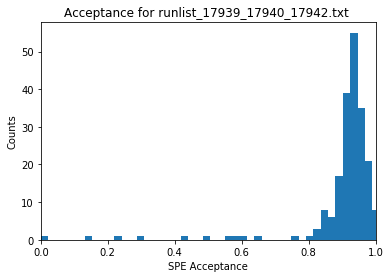

In [20]:
#plot the acceptance of one runlist
plt.hist(on_acc, bins=50, range=(0,1.1))
plt.title("Acceptance for %s " %newest_runlist)
plt.xlabel("SPE Acceptance")
plt.ylabel("Counts")
plt.xlim(0, 1)
plt.show()

#### Occupancy histogram for one runlist

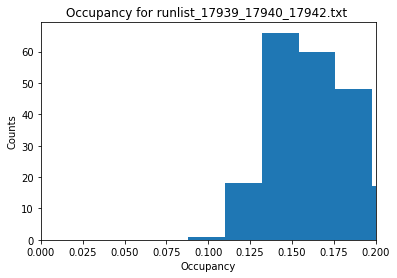

In [21]:
#plot the occupancy of one runlist
plt.hist(on_occ, bins=50, range=(0,1.1))
plt.title("Occupancy for %s " %newest_runlist)
plt.xlabel("Occupancy")
plt.ylabel("Counts")
plt.xlim(0,0.2)
plt.show()

#### Prints low acceptance channels

In [22]:
#prints list of low acc ch
cha_dict_new={}

for ch, a in zip(on_channels, on_acc):
    cha_dict_new[a]=ch
    
new_low_acc_ch=[]
for a in on_acc:
    if a<0.5:
        new_low_acc_ch.append(cha_dict_new[a])
        
print('Low acc ch for %s: ' %newest_runlist, new_low_acc_ch)

Low acc ch for runlist_17939_17940_17942.txt:  [27, 31, 73, 87, 91, 203]


#### Mean, Median, Errors for runlist

In [23]:
#maybe including off channels in mean
acc_mean=np.nanmean(ch_acc_dict[newest_runlist][on_channels])
acc_median=np.nanmedian(ch_acc_dict[newest_runlist])

print("Runlist: ", newest_runlist)
print("Mean Acceptance: ", acc_mean)
print("Median Acceptance: ", acc_median)
print("Errors [l,u]: ", [np.nanmean(ch_err_l[newest_runlist]), np.nanmean(ch_err_u[newest_runlist])])

Runlist:  runlist_17939_17940_17942.txt
Mean Acceptance:  0.91134116254
Median Acceptance:  0.929947166594
Errors [l,u]:  [0.0034410230770537818, 0.0033799575199848463]


## Average Acceptance per Runlist

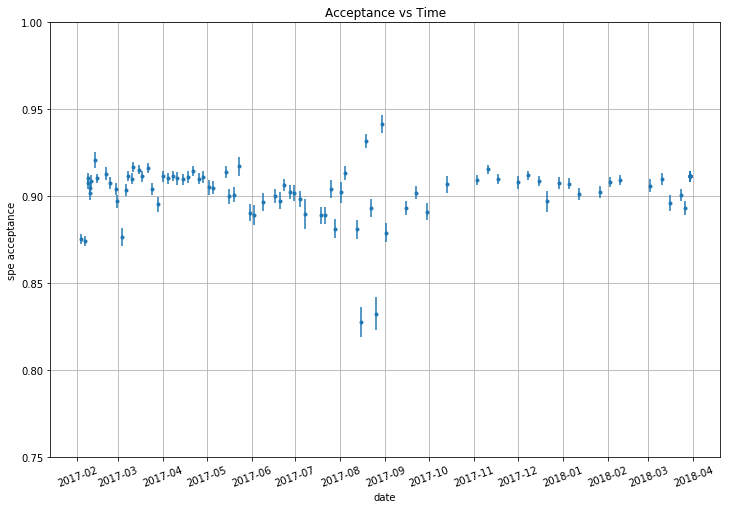

In [24]:
#plot acceptance vs time using full runlists

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%Y-%m')

bottom_runs = np.array(bottom_runs)

dates = np.array([get_run_time(run) for run in bottom_runs])

accs = np.array(accs)
#errors = np.array(errors)

noisy_runs = [12768, 13837]

sr1 = np.where(bottom_runs > 6731)
sr1 = [i for i in sr1[0] if bottom_runs[i] not in noisy_runs]

plot_dates = dates[sr1]
plot_runs = bottom_runs[sr1]
plot_accs = accs[sr1]
plot_errors = [errors[0][sr1],errors[1][sr1]]

f, ax = plt.subplots(figsize=(12,8))
ax.errorbar(plot_dates, plot_accs, yerr=plot_errors, linestyle='None', marker='.')
ax.set_ylim(0.75, 1.0)
plt.xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=20)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(fmt)
ax.grid()
ax.set_xlabel('date')
ax.set_ylabel('spe acceptance')

plt.title("Acceptance vs Time")

plt.savefig('new_moneyplot.png')
plt.show()

#### Mean, Median, Errors for all runlists

In [25]:
#add table of mean/median w errors for time evo, print days that are outliers

evo_mean=np.nanmean(plot_accs)
evo_median=np.nanmedian(plot_accs)
evo_errs=[np.nanmean(plot_errors[0]), np.nanmean(plot_errors[1])]

evo_std=np.nanstd(plot_accs)

print("All Runlists")
print("Mean :", evo_mean)
print("Median :", evo_median)
print("Errors [l, u]: ", evo_errs)

All Runlists
Mean : 0.902814746165
Median : 0.907059725989
Errors [l, u]:  [0.0040352995545818414, 0.0040064706298873097]


## Acceptance for Individual Channels

### One Channel

#### Plots acceptances of one channel for all runlists

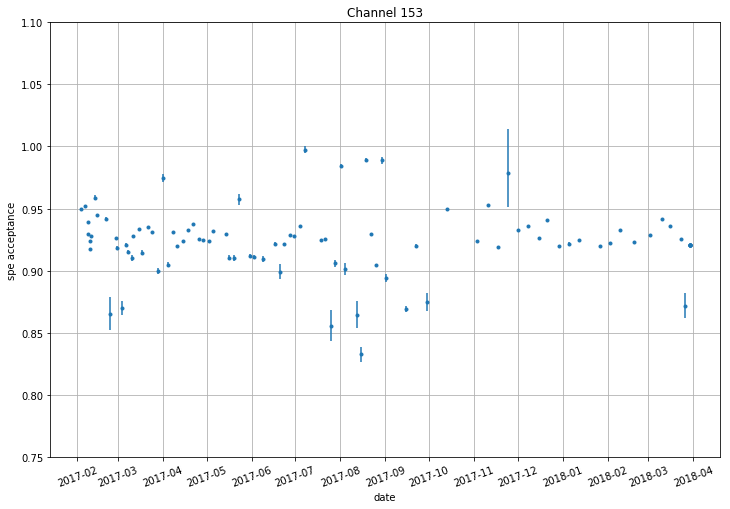

In [26]:
ch=153

#list of lists of runlists
sr1_rl=[find_file(i) for i in bottom_runs[sr1]]

#list of runlists
sr1_rl=[runlist for elem in sr1_rl for runlist in elem]

plt.figure(figsize=(12,8))
plt.errorbar(plot_dates, ch_df.loc[ch, sr1_rl] , yerr=[ch_lerr_df.loc[ch, sr1_rl], ch_uerr_df.loc[ch, sr1_rl]], linestyle='None', marker='.')
plt.ylim(0.75, 1.1)
plt.xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=20)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(fmt)
plt.grid()
plt.title("Channel %s" %ch)
plt.xlabel('date')
plt.ylabel('spe acceptance')
plt.show()

#### Prints runlists with low acceptance for one channel

In [27]:
#prints list of low acc runlists

ch_accs=np.array(ch_df.loc[ch])

low_acc=np.where(ch_accs<0.85)

low_acc_rl=list(ch_df.columns[low_acc])
        
print('Low acc runlists for ch %s: ' %ch, low_acc_rl)

Low acc runlists for ch 153:  ['runlist_12130_12131_12132.txt', 'runlist_13837_13838_13839.txt']


# Further Analysis

### Find outliers, plot the acceptance curve, acceptance histogram, and occupancy histogram

#### Change the index in run=outliers[index] in order to change which outlier gets plotted

Outliers : [12130 12398 13837 12511 12768]
Run:  12130


/project/lgrandi/anaconda3/envs/pax_v6.8.0/lib/python3.4/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/project/lgrandi/anaconda3/envs/pax_v6.8.0/lib/python3.4/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater
/home/awalsh272/SPE/SPE/analyze.py:72: RuntimeWarning: invalid value encountered in true_divide
  sigma_corr_noise=corr_noise*np.sqrt( (sigma_corr/corrections)**2 + (sigma_noise/noise)**2)
/home/awalsh272/SPE/SPE/analyze.py:106: RuntimeWarning: divide by zero encountered in true_divide
  acc =  1 - residual.cumsum(axis=1) / residual.sum(axis=1)[:, np.newaxis]
/home/awalsh272/SPE/SPE/analyze.py:106: RuntimeWarning: invalid value encountered in true_divide
  acc =  1 - residual.cumsum(axis=1) / residual.sum(axis=1)[:, np.newaxis]


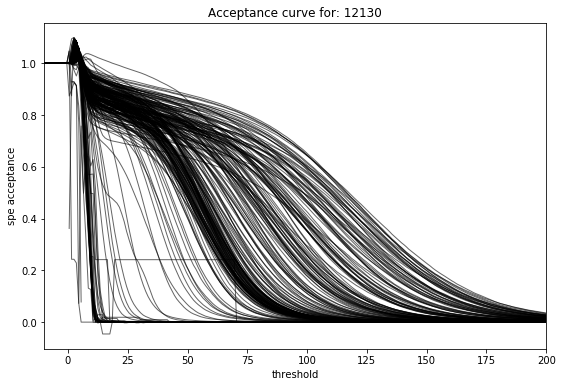

In [28]:
#Find outliers, plot acc of one of them

outlier_indices_low = np.array(np.where(accs < (evo_mean-2*evo_std))).flatten()
outlier_indices_high= np.array(np.where(accs > (evo_mean+2*evo_std))).flatten()

outlier_indices=outlier_indices_low.tolist() + outlier_indices_high.tolist()

outliers = bottom_runs[outlier_indices]
print("Outliers :", outliers)
run = outliers[0] #change index to change which outlier
print('Run: ',run)
runlist = file_to_list(find_file(run)[0])

bot_run=runlist[0]
tb_run=runlist[1]
tr_run=runlist[2]

x, acc, err = analyze.acceptance_curve_3runs(bot_run, tb_run, tr_run)

plt.figure(figsize=(9,6))
for ch, a in enumerate(acc):
    plt.plot(x, a, color='black', linewidth=1, alpha=0.6)
    plt.title("Acceptance curve for: %d" %run)
    
plt.xlim(-10, 200)
plt.xlabel('threshold')
plt.ylabel('spe acceptance')
plt.show()

In [29]:
#doesn't save the data
thresholds = analyze.get_thresholds(analyze.find_regular_run(bot_run))
acc, acc_errs, acc_sys, acc_stat = analyze.acceptance_3runs(bot_run, tb_run, tr_run, thresholds)
occ, occ_sys, occ_stat = analyze.occupancy_3runs(bot_run, tb_run, tr_run)

on_channels = np.where(occ > 0.05)[0]

acc=acc[on_channels]
occ=occ[on_channels]

/home/awalsh272/SPE/SPE/analyze.py:72: RuntimeWarning: invalid value encountered in true_divide
  sigma_corr_noise=corr_noise*np.sqrt( (sigma_corr/corrections)**2 + (sigma_noise/noise)**2)
/home/awalsh272/SPE/SPE/analyze.py:106: RuntimeWarning: divide by zero encountered in true_divide
  acc =  1 - residual.cumsum(axis=1) / residual.sum(axis=1)[:, np.newaxis]
/home/awalsh272/SPE/SPE/analyze.py:106: RuntimeWarning: invalid value encountered in true_divide
  acc =  1 - residual.cumsum(axis=1) / residual.sum(axis=1)[:, np.newaxis]


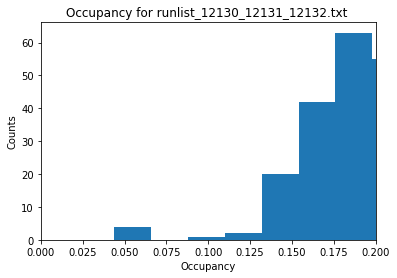

In [30]:
#plot the occupancy of one runlist
plt.hist(occ, bins=50, range=(0,1.1))
plt.title("Occupancy for %s " %find_file(run)[0])
plt.xlabel("Occupancy")
plt.ylabel("Counts")
plt.xlim(0,0.2)
plt.show()

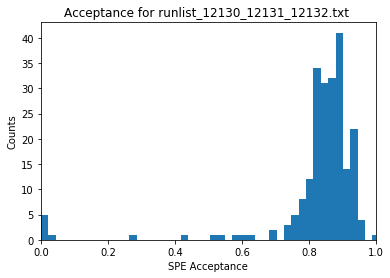

In [31]:
#plot the acceptance of one runlist
plt.hist(acc, bins=50, range=(0,1.1))
plt.title("Acceptance for %s " %find_file(run)[0])
plt.xlabel("SPE Acceptance")
plt.ylabel("Counts")
plt.xlim(0, 1)
plt.show()

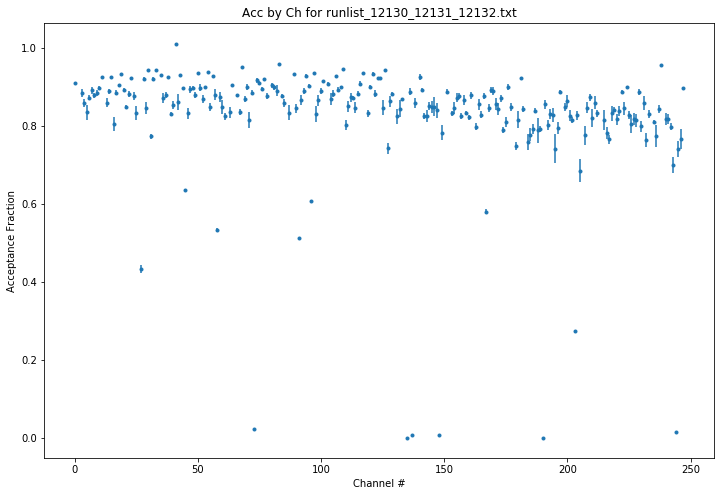

In [32]:
runlist= find_file(run)[0]

#plot acceptance of each channel
plt.figure()
plt.figure(figsize=(12,8))
plt.errorbar(on_channels, acc, yerr=[ch_lerr_df.loc[on_channels, runlist], ch_uerr_df.loc[on_channels,runlist]], marker='.', linestyle='none')
plt.ylabel('Acceptance Fraction')
plt.xlabel('Channel #')
plt.title('Acc by Ch for %s' %runlist)
plt.show()

In [33]:
cha_dict={}

for ch, a in zip(on_channels, acc):
    cha_dict[a]=ch
    
low_acc_ch=[]
for a in acc:
    if a<0.5:
        low_acc_ch.append(cha_dict[a])
        
print('Low acc ch: ', low_acc_ch)

Low acc ch:  [27, 73, 135, 137, 148, 190, 203, 244]
